In [1]:
import pandas as pd
import sqlite3
from pathlib import Path
import re
import numpy as np
from scipy.stats import skew
from funcz import *
import warnings
import duckdb
import ipywidgets as widgets
from IPython.display import display
warnings.filterwarnings('ignore')
engine = duckdb.connect('my_db.duckdb')

In [ ]:
df = pd.read_sql(con=engine, sql='''

 -------------------------------------------------------------------------------------------------------------------
--Demographic Data
-------------------------------------------------------------------------------------------------------------------
WITH demo_cte AS (
  SELECT 
  dd.year, 
  dd.community_board,
  SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS total_population,
  SUM(CASE WHEN dd.metric = 'Under 18 Population' THEN dd.value ELSE 0 END) / SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS youth_population,
  SUM(CASE WHEN dd.metric = 'Average Household Size' THEN dd.value ELSE 0 END) AS average_household_size,
  SUM(CASE WHEN dd.metric = 'Black Population' THEN dd.value ELSE 0 END) / SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS black_population,
  SUM(CASE WHEN dd.metric = 'White Population' THEN dd.value ELSE 0 END) / SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS white_population,
  SUM(CASE WHEN dd.metric = 'Asian Population' THEN dd.value ELSE 0 END) / SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS asian_population
  FROM demo_data dd 
  GROUP BY 1,2
),
-------------------------------------------------------------------------------------------------------------------
--Pop Data
-------------------------------------------------------------------------------------------------------------------
pop_data AS (
  SELECT 
  un.YEAR,
  un.community_board,
  un.unemployment_rate,
  un.unemployment_rate - LAG(un.unemployment_rate) OVER(PARTITION BY un.community_board ORDER BY un.year) AS unemployment_change,
  rd.rent/(inc.median_income/12) AS rent_proportion,
  (rd.rent/(inc.median_income/12)) - 
  (LAG(rd.rent) OVER(PARTITION BY un.community_board ORDER BY un.YEAR) / LAG(inc.median_income) OVER(PARTITION BY un.community_board ORDER BY un.year) ) AS rent_proportion_change 
  FROM unemployment_rate_data un
  LEFT JOIN rent_data rd ON un.YEAR = rd.YEAR AND un.community_board = rd.community_board 
  LEFT JOIN (
      SELECT 
      inc.YEAR,
      inc.community_board,
      inc.median_income
      FROM median_income_data inc
  ) inc ON un.year = inc.YEAR AND un.community_board  = inc.community_board
),
-------------------------------------------------------------------------------------------------------------------
--Education Data on a DBN, Year Level
-------------------------------------------------------------------------------------------------------------------
education_data_dbn AS (
    SELECT DISTINCT
    CAST(split_part(sp.YEAR,'-',2) AS int) AS YEAR,
    sp.dbn,
    COALESCE(
      sp.score,
      AVG(score) OVER (PARTITION BY split_part(sp.YEAR, '-', 2), LEFT(sp.dbn, 3))
    ) AS score
    FROM school_performance sp
),
-------------------------------------------------------------------------------------------------------------------
--Education Data on a Community Board, Year Level
-------------------------------------------------------------------------------------------------------------------
education_data AS (
  SELECT
  split_part(sd.community_board,'.',1) AS community_board,
  ed.YEAR,
  AVG(score) AS score
  FROM education_data_dbn ed
  LEFT JOIN school_data sd ON ed.dbn = sd.dbn
  GROUP BY 1,2
),
-------------------------------------------------------------------------------------------------------------------
--Crime Data
-------------------------------------------------------------------------------------------------------------------
crime_data_CTE AS (
  SELECT community_board, year, SUM(crimes) AS crimes FROM (
  SELECT 
  pd.community_board, 
  pd.precinct,
  cd.YEAR,
  crimes/COUNT(community_board) OVER(PARTITION BY cd.YEAR,pd.precinct) AS crimes
  FROM precinct_data pd 
  LEFT JOIN (
    select
    cd.YEAR,
    cd.pct,
    SUM(count) AS crimes
    FROM crime_data cd
    WHERE crime_category IN ('major','non-major')
    GROUP BY 1,2
  ) cd ON pd.precinct  = cd.pct 
) sq GROUP BY 1,2
),
-------------------------------------------------------------------------------------------------------------------
--Base CTE
-------------------------------------------------------------------------------------------------------------------
base_CTE AS (
  SELECT 
  cb.community_board,
  unnest(ye.year) as year
  FROM community_board_data cb
  CROSS JOIN (SELECT generate_series(2007, 2024) AS YEAR) ye
)

SELECT 
b.community_board,
b.YEAR,
COALESCE(ed.score, AVG(ed.score) OVER (PARTITION BY b.community_board)) AS grade_school_score,
(cd.crimes/dc.total_population) * 100000 AS crime_rate,
LAG(cd.crimes) OVER (PARTITION BY b.community_board ORDER BY b.YEAR) / LAG(dc.total_population) OVER (PARTITION BY b.community_board ORDER BY b.YEAR) * 100000 AS lag_crime_rate,
CASE WHEN dc.white_population >= 0.51 THEN 1 ELSE 0 END AS white_majority,
dc.average_household_size,
pd.unemployment_rate,
pd.unemployment_change,
pd.rent_proportion,
pd.rent_proportion_change,
pd.unemployment_rate * pd.rent_proportion AS economic_hardship,
pd.unemployment_change * pd.rent_proportion_change AS economic_hardship_volatility,
dc.average_household_size * pd.rent_proportion AS household_strain

FROM base_CTE b
LEFT JOIN education_data ed ON b.community_board = ed.community_board AND b.YEAR = ed.YEAR
LEFT JOIN demo_cte dc ON b.community_board = dc.community_board AND b.YEAR = dc.YEAR
LEFT JOIN crime_data_CTE cd ON b.community_board = cd.community_board AND b.YEAR = cd.YEAR 
LEFT JOIN pop_data pd ON b.community_board = pd.community_board AND b.YEAR = pd.YEAR




                      
                       
'''                        )

## 3.2.2 Correlation and Multicollinearity (With Interaction Terms)


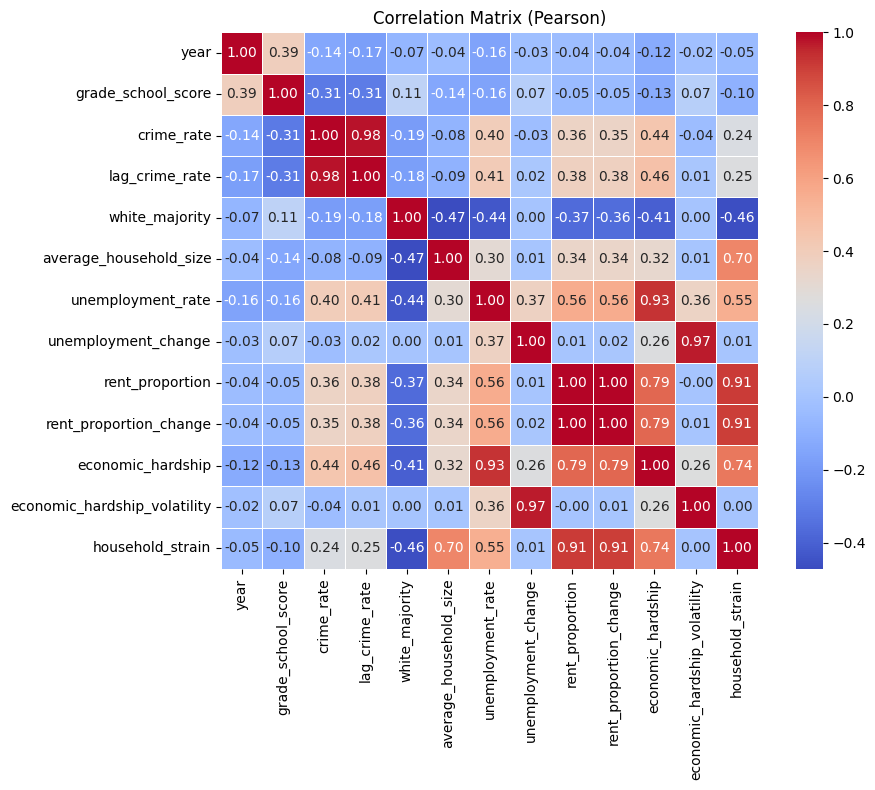

,variable,VIF
0,const,1838.714114
1,grade_school_score,1.209166
2,lag_crime_rate,1.607967
3,white_majority,1.738547
4,average_household_size,38.941931
5,unemployment_rate,26.526210
6,unemployment_change,20.860724
7,rent_proportion,752.048956
8,rent_proportion_change,570.605772
9,economic_hardship,45.294915


In [6]:
stat_dude = StatWhiz(data=df)
stat_dude.correlation_matrix()
stat_dude.test_multicollinearity(excluded_vars=["year","crime_rate"])

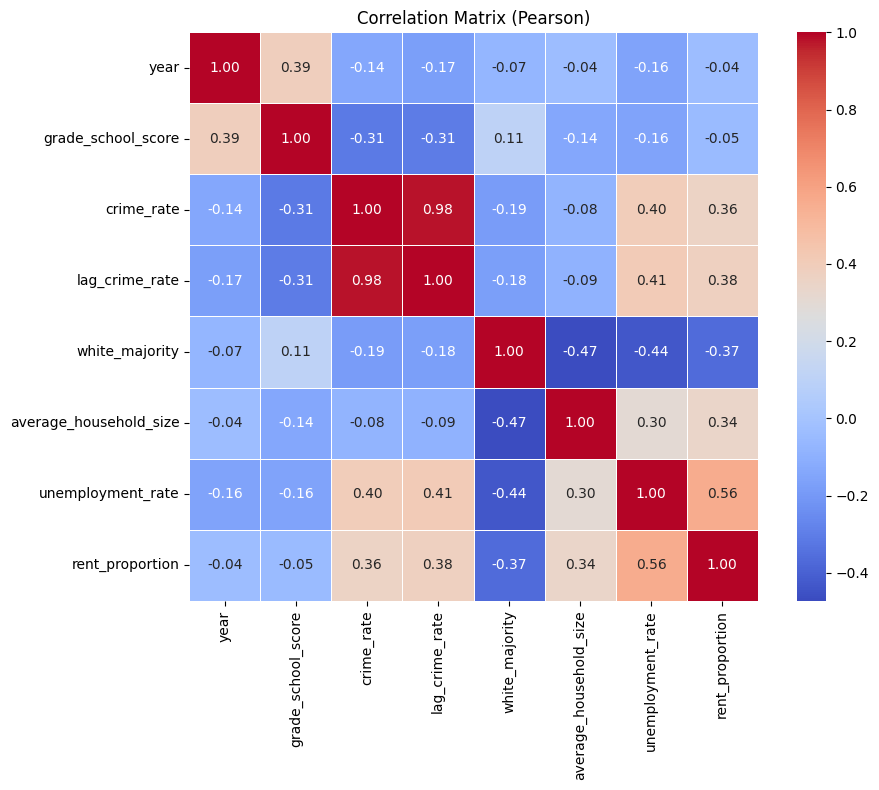

,variable,VIF
0,const,222.457084
1,grade_school_score,1.174164
2,lag_crime_rate,1.530473
3,white_majority,1.468640
4,average_household_size,1.531715
5,unemployment_rate,1.753777
6,rent_proportion,1.679793


In [4]:
stat_dude = StatWhiz(data=df.drop(columns=["economic_hardship","household_strain","economic_hardship_volatility","rent_proportion_change","unemployment_change"]))
stat_dude.correlation_matrix()
stat_dude.test_multicollinearity(excluded_vars=["year","crime_rate"])

## 3.2.3: Feature Transformations:

In [ ]:
stat_dude = StatWhiz(data=df, entity="community_board",time="year",dep="crime_rate")
stat_dude.plot_diagnostics()

In [ ]:
stat_dude.plot_diagnostics(fix="no")

## 3.3: Fitting the Model

## 3.3.1: Fixed Effect

In [9]:
stat_dude = StatWhiz(data=df)
model = stat_dude.panel_regression(entity_col="community_board",time_col="year",dep_var="crime_rate")

Fixed Effects Model (Cluster-Robust SE):
                           PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.7158
Estimator:                   PanelOLS   R-squared (Between):              0.9873
No. Observations:                 986   R-squared (Within):               0.7158
Date:                Sun, May 25 2025   R-squared (Overall):              0.9817
Time:                        21:42:44   Log-likelihood                   -6446.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      210.00
Entities:                          58   P-value                           0.0000
Avg Obs:                       17.000   Distribution:                  F(11,917)
Min Obs:                       17.000                                           
Max Obs:                       17.000   F-statistic (robust):      

## 3.3.2: Random Effect

In [10]:
model = stat_dude.panel_regression(entity_col="community_board",time_col="year",dep_var="crime_rate",effect_type="random")

Random Effects Model (Cluster-Robust SE):
                         RandomEffects Estimation Summary                        
Dep. Variable:             crime_rate   R-squared:                        0.9930
Estimator:              RandomEffects   R-squared (Between):              0.9997
No. Observations:                 986   R-squared (Within):               0.6735
Date:                Sun, May 25 2025   R-squared (Overall):              0.9930
Time:                        21:42:46   Log-likelihood                   -6537.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.257e+04
Entities:                          58   P-value                           0.0000
Avg Obs:                       17.000   Distribution:                  F(11,975)
Min Obs:                       17.000                                           
Max Obs:                       17.000   F-statistic (robust):     

## 3.3: Evaluatinon (Hausman Test)

In [ ]:
model = stat_dude.(entity_col="community_board",time_col="year",dep_var="crime_rate",effect_type="fixed",hausman=True)

=== Without Cluster-Robust SE ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.7158
Estimator:                   PanelOLS   R-squared (Between):              0.9873
No. Observations:                 986   R-squared (Within):               0.7158
Date:                Sun, May 25 2025   R-squared (Overall):              0.9817
Time:                        21:42:55   Log-likelihood                   -6446.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      210.00
Entities:                          58   P-value                           0.0000
Avg Obs:                       17.000   Distribution:                  F(11,917)
Min Obs:                       17.000                                           
Max Obs:                       17.000   F-statistic (robust):             2

## 3.4: Testing for Heteroscedasticity

## 3.4.1: Comparing Default and Clustered Standard Errors

In [1]:
model = stat_dude.panel_regression(entity_col="community_board",time_col="year",dep_var="crime_rate")
model

NameError: name 'stat_dude' is not defined

## 3.4.2: Wald Test and Residual Plots

In [ ]:
model = stat_dude.test_heteroskedasticity(entity_col="community_board",time_col="year",dep_var="crime_rate")